In [ ]:
# =============================================================================
#       COPYRIGHT NOTICE
#       Copyright (c) 2022
#       All rights reserved
#
#       @author       :Wei Yuhan
#       @name         :Music Genre Classification with ResNet
#       @file         :Resnet_Project.ipynb
#       @date         :2022/04/10 15:30
#       @package      :torch == 1.11.0, torchvision == 0.12.0
#       @reference    :https://medium.com/swlh/music-genre-classification-using-transfer-learning-pytorch-ea1c23e36eb8
# =============================================================================

In [1]:
import torch
import torchvision
# import torchaudio
import random
import numpy as np
import pandas as pd
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from tqdm.autonotebook import tqdm
import IPython.display as ipd
import torchvision.transforms as T

In [2]:
img_path = './Data/images_original'

In [3]:
batch_size = 8
image_size = 224

In [4]:
train_trms = T.Compose([
                        T.Resize(image_size),
                        T.RandomRotation(20),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()
                        ])
val_trms = T.Compose([
                        T.Resize(image_size),
                        T.ToTensor()
                        ])

In [5]:
train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trms)

In [6]:
def Encode(data):
    classes = data.classes
    encoder = {}
    for i in range(len(classes)):
        encoder[i] = classes[i]
    return encoder

def Decoder(data):
    classes = data.classes
    
    decoder = {}
    for i in range(len(classes)):
        decoder[classes[i]] = i
    return decoder

In [7]:
def class_plot(data,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        label = int(label)
        encoder = Encode(data)
        l = encoder[label]
       
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

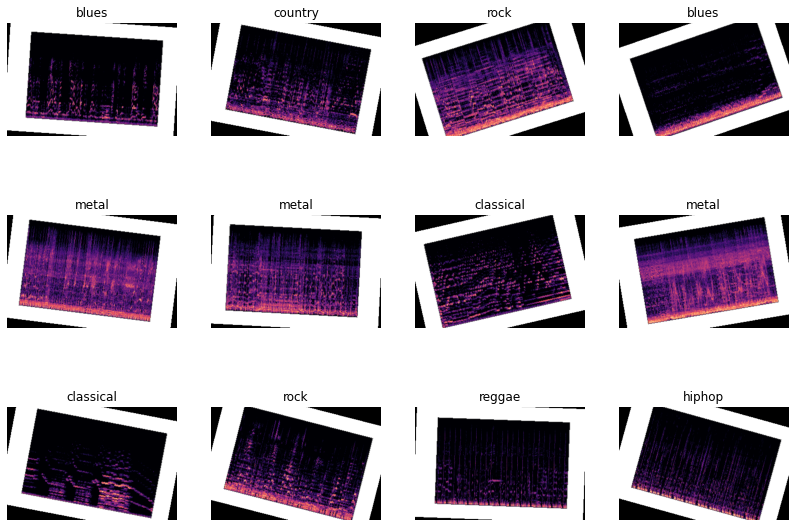

In [8]:
class_plot(train_data)

In [9]:
torch.manual_seed(43)
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - val_size

In [10]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)

(900, 99)

In [11]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([8, 3, 224, 336])


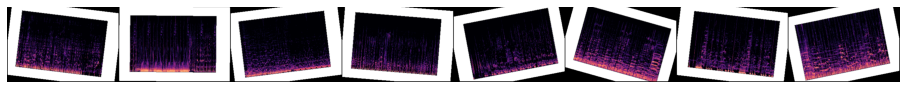

In [12]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [13]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [14]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['val_loss'], result['val_score']))

In [57]:
import torchvision.models as models
class Net(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return self.network(xb)
    def freeze(self):
      for param in self.network.parameters():
        param.require_grad = False
      for param in self.network.fc.parameters():
        param.require_grad = True
    
    def unfreeze(self):
      for param in self.network.parameters():
        param.require_grad = True

In [58]:
Net()

Net(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [59]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [60]:
@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def train_model(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [61]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [62]:
device = get_default_device()
device

device(type='cuda')

In [63]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [64]:
model = to_device(Net(), device)

In [65]:
torch.cuda.empty_cache()

In [66]:
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

### Resnet50

In [ ]:
model.freeze()

In [41]:
# Resnet50
history = train_model(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.6569, val_score: 0.4018


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.8275, val_score: 0.2946


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.5872, val_score: 0.4196


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.3868, val_score: 0.4554


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.3144, val_score: 0.4821


In [42]:
model.unfreeze()

In [44]:
# Resnet50
history = train_model(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.5967, val_score: 0.4583


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.5857, val_score: 0.4196


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.3247, val_score: 0.5863


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.1828, val_score: 0.6220


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.1113, val_score: 0.6696


### Resnet34

In [53]:
model.freeze()

In [54]:
# Resnet34
history = train_model(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.7855, val_score: 0.4702


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 2.0413, val_score: 0.3214


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.6590, val_score: 0.4196


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.2533, val_score: 0.5179


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.2132, val_score: 0.5833


In [55]:
model.unfreeze()

In [56]:
# Resnet34
history = train_model(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.8520, val_score: 0.3661


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.7336, val_score: 0.3661


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.4967, val_score: 0.5060


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.2208, val_score: 0.6310


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.1809, val_score: 0.6220


In [121]:
%%time
# Resnet34
history = train_model(100, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.1469, val_score: 0.6488


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.1474, val_score: 0.6310


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.0797, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.1413, val_score: 0.6280


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.2263, val_score: 0.5357


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.2236, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.1172, val_score: 0.6458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.2704, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.4050, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.3572, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.1666, val_score: 0.6756


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.4188, val_score: 0.5744


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.3830, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.0708, val_score: 0.7411


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.2631, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.3741, val_score: 0.5893


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.2724, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17], val_loss: 1.3287, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.0536, val_score: 0.6190


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.5904, val_score: 0.5179


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [20], val_loss: 1.1913, val_score: 0.6399


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [21], val_loss: 1.4343, val_score: 0.5089


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [22], val_loss: 1.4766, val_score: 0.5625


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [23], val_loss: 1.1219, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [24], val_loss: 1.2007, val_score: 0.6280


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [25], val_loss: 1.3459, val_score: 0.6310


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [26], val_loss: 1.1723, val_score: 0.5685


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [27], val_loss: 1.2031, val_score: 0.6548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [28], val_loss: 1.2651, val_score: 0.6756


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [29], val_loss: 1.2171, val_score: 0.6369


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [30], val_loss: 1.2021, val_score: 0.6399


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [31], val_loss: 1.1898, val_score: 0.6161


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [32], val_loss: 1.2726, val_score: 0.5357


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [33], val_loss: 1.2891, val_score: 0.5714


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [34], val_loss: 1.1902, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [35], val_loss: 1.4242, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [36], val_loss: 1.0863, val_score: 0.6161


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [37], val_loss: 1.3061, val_score: 0.5804


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [38], val_loss: 1.3163, val_score: 0.6458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [39], val_loss: 1.0746, val_score: 0.6935


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [40], val_loss: 0.9738, val_score: 0.7024


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [41], val_loss: 1.2852, val_score: 0.6756


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [42], val_loss: 1.5138, val_score: 0.6310


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [43], val_loss: 1.2247, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [44], val_loss: 1.6233, val_score: 0.5268


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [45], val_loss: 1.3815, val_score: 0.5982


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [46], val_loss: 1.1850, val_score: 0.6935


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [47], val_loss: 1.4142, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [48], val_loss: 1.6383, val_score: 0.5536


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [49], val_loss: 1.5472, val_score: 0.6369


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [50], val_loss: 1.6486, val_score: 0.5268


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [51], val_loss: 1.1616, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [52], val_loss: 1.2681, val_score: 0.6845


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [53], val_loss: 1.5187, val_score: 0.5804


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [54], val_loss: 1.2439, val_score: 0.6280


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [55], val_loss: 1.4243, val_score: 0.5893


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [56], val_loss: 1.7817, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [57], val_loss: 1.5313, val_score: 0.5804


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [58], val_loss: 1.2526, val_score: 0.6250


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [59], val_loss: 1.6573, val_score: 0.6458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [60], val_loss: 1.4043, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [61], val_loss: 1.4407, val_score: 0.6280


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [62], val_loss: 1.7522, val_score: 0.6071


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [63], val_loss: 1.3603, val_score: 0.6161


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [64], val_loss: 1.5193, val_score: 0.5982


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [65], val_loss: 1.4583, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [66], val_loss: 1.4721, val_score: 0.5536


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [67], val_loss: 1.4500, val_score: 0.5893


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [68], val_loss: 1.5804, val_score: 0.6369


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [69], val_loss: 1.7703, val_score: 0.5714


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [70], val_loss: 1.6895, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [71], val_loss: 1.6372, val_score: 0.6548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [72], val_loss: 1.4780, val_score: 0.6548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [73], val_loss: 1.4147, val_score: 0.5893


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [74], val_loss: 1.4228, val_score: 0.6250


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [75], val_loss: 1.3806, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [76], val_loss: 1.7583, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [77], val_loss: 1.5602, val_score: 0.6250


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [78], val_loss: 1.5942, val_score: 0.6250


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [79], val_loss: 1.6141, val_score: 0.6429


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [80], val_loss: 1.6185, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [81], val_loss: 1.5180, val_score: 0.6071


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [82], val_loss: 1.5828, val_score: 0.6518


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [83], val_loss: 1.5792, val_score: 0.6786


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [84], val_loss: 1.7519, val_score: 0.6518


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [85], val_loss: 1.4380, val_score: 0.6607


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [86], val_loss: 1.5919, val_score: 0.6071


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [87], val_loss: 1.5916, val_score: 0.5982


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [88], val_loss: 1.6012, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [89], val_loss: 1.5437, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [90], val_loss: 1.2790, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [91], val_loss: 1.3164, val_score: 0.6250


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [92], val_loss: 1.7260, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [93], val_loss: 1.6366, val_score: 0.6518


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [94], val_loss: 1.4635, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [95], val_loss: 1.3088, val_score: 0.6845


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [96], val_loss: 1.4532, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [97], val_loss: 1.4566, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [98], val_loss: 1.5598, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [99], val_loss: 1.2782, val_score: 0.7083
CPU times: user 11min 54s, sys: 4min 2s, total: 15min 57s
Wall time: 20min 2s


### Resnet18

In [67]:
model.freeze()

In [68]:
# Resnet18
history = train_model(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 2.4327, val_score: 0.1696


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.9011, val_score: 0.3036


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.3481, val_score: 0.5863


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.1885, val_score: 0.6042


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.1780, val_score: 0.5476


In [69]:
model.unfreeze()

In [111]:
epochs = 5
max_lr = 0.000001
grad_clip = 0.3
weight_decay = 5e-3
opt_func = torch.optim.Adam

In [127]:
# Resnet18
history = train_model(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.0009, val_score: 0.7560


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.1941, val_score: 0.6429


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.0340, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.0433, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.0644, val_score: 0.7351


In [128]:
%%time
# Resnet18
history += train_model(50, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 0.9739, val_score: 0.7827


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.0466, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.1350, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.0747, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 0.8818, val_score: 0.7560


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.1411, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 0.9706, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.1754, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.0419, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.1317, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 0.9987, val_score: 0.7649


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 0.9901, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.0587, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 0.9716, val_score: 0.7292


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.0234, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.1363, val_score: 0.6607


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.1074, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17], val_loss: 1.0204, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.1149, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.1656, val_score: 0.6518


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [20], val_loss: 1.0988, val_score: 0.6518


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [21], val_loss: 1.0896, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [22], val_loss: 1.1024, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [23], val_loss: 1.0960, val_score: 0.6429


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [24], val_loss: 1.1468, val_score: 0.6786


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [25], val_loss: 1.0444, val_score: 0.7351


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [26], val_loss: 1.0166, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [27], val_loss: 1.2022, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [28], val_loss: 0.9870, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [29], val_loss: 0.9851, val_score: 0.7649


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [30], val_loss: 0.9805, val_score: 0.6607


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [31], val_loss: 1.1107, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [32], val_loss: 0.9618, val_score: 0.7292


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [33], val_loss: 1.0541, val_score: 0.6786


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [34], val_loss: 1.1332, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [35], val_loss: 1.1485, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [36], val_loss: 1.1494, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [37], val_loss: 1.0946, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [38], val_loss: 1.0459, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [39], val_loss: 0.9777, val_score: 0.7560


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [40], val_loss: 1.1780, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [41], val_loss: 1.0851, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [42], val_loss: 1.1596, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [43], val_loss: 0.9742, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [44], val_loss: 0.9665, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [45], val_loss: 1.0912, val_score: 0.7649


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [46], val_loss: 1.0867, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [47], val_loss: 0.9989, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [48], val_loss: 1.1192, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [49], val_loss: 0.9846, val_score: 0.7470
CPU times: total: 3min 13s
Wall time: 6min 26s


In [129]:
# Resnet18
history += train_model(100, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.1195, val_score: 0.7470


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.0875, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 0.9985, val_score: 0.6250


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 0.9981, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.1142, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.0594, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.0687, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.0137, val_score: 0.7470


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.0739, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.0428, val_score: 0.7292


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.0885, val_score: 0.7351


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.1217, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 0.9605, val_score: 0.7470


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.0045, val_score: 0.7292


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.0049, val_score: 0.7470


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.0280, val_score: 0.6696


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.0888, val_score: 0.6429


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17], val_loss: 1.0387, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.0892, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.0420, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [20], val_loss: 1.0677, val_score: 0.6339


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [21], val_loss: 1.0335, val_score: 0.7202


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [22], val_loss: 1.0961, val_score: 0.6518


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [23], val_loss: 1.1201, val_score: 0.6161


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [24], val_loss: 1.0124, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [25], val_loss: 1.0590, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [26], val_loss: 1.0498, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [27], val_loss: 1.0711, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [28], val_loss: 1.0971, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [29], val_loss: 1.0312, val_score: 0.6518


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [30], val_loss: 1.0841, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [31], val_loss: 1.0419, val_score: 0.6429


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [32], val_loss: 1.0157, val_score: 0.7470


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [33], val_loss: 1.0012, val_score: 0.7470


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [34], val_loss: 0.9446, val_score: 0.7470


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [35], val_loss: 0.9539, val_score: 0.7470


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [36], val_loss: 0.9824, val_score: 0.7560


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [37], val_loss: 1.0936, val_score: 0.7202


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [38], val_loss: 1.0688, val_score: 0.7560


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [39], val_loss: 1.1039, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [40], val_loss: 1.1212, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [41], val_loss: 1.0092, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [42], val_loss: 1.1099, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [43], val_loss: 1.1256, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [44], val_loss: 1.0504, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [45], val_loss: 1.0830, val_score: 0.7381


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [46], val_loss: 1.0323, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [47], val_loss: 1.1370, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [48], val_loss: 1.0616, val_score: 0.7560


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [49], val_loss: 1.0903, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [50], val_loss: 1.0292, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [51], val_loss: 1.1621, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [52], val_loss: 1.1245, val_score: 0.7262


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [53], val_loss: 1.0206, val_score: 0.6607


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [54], val_loss: 1.0059, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [55], val_loss: 1.0027, val_score: 0.7470


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [56], val_loss: 1.1476, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [57], val_loss: 1.0486, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [58], val_loss: 1.1680, val_score: 0.6548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [59], val_loss: 1.1011, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [60], val_loss: 1.0229, val_score: 0.7381


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [61], val_loss: 1.0752, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [62], val_loss: 1.0982, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [63], val_loss: 1.1877, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [64], val_loss: 1.1601, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [65], val_loss: 1.1531, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [66], val_loss: 1.1426, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [67], val_loss: 1.1822, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [68], val_loss: 1.0920, val_score: 0.7173


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [69], val_loss: 1.0878, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [70], val_loss: 1.0314, val_score: 0.7649


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [71], val_loss: 1.1141, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [72], val_loss: 1.0457, val_score: 0.7470


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [73], val_loss: 1.0960, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [74], val_loss: 1.0560, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [75], val_loss: 1.0467, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [76], val_loss: 1.0242, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [77], val_loss: 0.9943, val_score: 0.7649


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [78], val_loss: 1.1173, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [79], val_loss: 1.0567, val_score: 0.7381


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [80], val_loss: 1.1840, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [81], val_loss: 1.2067, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [82], val_loss: 0.9820, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [83], val_loss: 1.1464, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [84], val_loss: 1.0927, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [85], val_loss: 1.0188, val_score: 0.7560


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [86], val_loss: 1.0490, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [87], val_loss: 1.0269, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [88], val_loss: 1.0874, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [89], val_loss: 1.0424, val_score: 0.7381


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [90], val_loss: 1.1217, val_score: 0.6339


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [91], val_loss: 1.0690, val_score: 0.6548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [92], val_loss: 1.0825, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [93], val_loss: 1.1372, val_score: 0.6518


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [94], val_loss: 1.0325, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [95], val_loss: 1.0810, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [96], val_loss: 1.0594, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [97], val_loss: 1.1119, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [98], val_loss: 1.1240, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [99], val_loss: 1.0377, val_score: 0.7560


In [130]:
max_val_score = 0
for i in range(len(history)):
    if max_val_score < history[i]['val_score']:
        max_val_score = history[i]['val_score']

print('max val_score:', max_val_score)

max val_score: 0.7827381491661072


In [ ]:
torch.save(model.state_dict(), '/content/model.pth')